# Random guided sequence generator

In [1]:
from datetime import date
from pycltools.pycltools import jprint

jprint('Adrien Leger / EMBL EBI', bold=True, size=150)
jprint('Starting date : 2019_02_12', bold=True, italic=True, size=125)
jprint('Last modification date : {}_{:02}_{:02}'.format(date.today().year, date.today().month, date.today().day), bold=True, italic=True, size=125)

## Imports

In [2]:
# Standard lib imports
import os
from datetime import date
from collections import *
import random
from glob import glob, iglob
from shutil import rmtree
import itertools
from pprint import pprint as pp
import gzip

# Generic third party imports
from pycltools.pycltools import *
import pysam
import pyfaidx
from tqdm import trange, tqdm
from skbio.alignment import StripedSmithWaterman
from skbio import DNA

# Ploting lib imports
import matplotlib.pyplot as pl
import seaborn as sns
%matplotlib inline

# Data wrangling lib imports
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

## Generate a random guided reference set 

**The function randomly picks a kmer based on weight equals to the inverse of the representation of each possible kmer in the previously generated sequences**

In [3]:
def random_guided_weight (fasta_fn, alphabet=["A","G","T","C"], kmer_len=7, hp_max=4, seq_len=500, n_seq=100, seed=None):
    
    random.seed(seed)
    np.random.seed(seed)
    
    kmer_c = Counter()
    with open (fasta_fn, "w") as fasta_fp:
        for seq_num in trange(n_seq):
            seq = []

            # First base
            hp = 1
            seq.append(random.choice(alphabet))

            # Extend seed to length kmer_len
            for i in range(kmer_len-1):
                # Reduce choice if max homopolymer reached
                choices = [i for i in alphabet if i!=seq[-1]] if hp >= hp_max else alphabet
                # Sample from available choices
                seq.append(random.choice(choices))
                # Check if homopolymers extends
                hp = hp+1 if seq[-2] == seq[-1] else 1
            kmer_c["".join(seq)] += 1

            # Extend sequence
            for _ in range (seq_len-kmer_len):
                count_d = defaultdict(list)
                prev = seq[-kmer_len+1:]

                # Reduce choice if max homopolymer reached
                choices = [i for i in alphabet if i!=seq[-1]] if hp >= hp_max else alphabet    

                # Collect count for each possible kmers and transform to weights
                p = []
                for b in choices:
                    kmer = "".join(prev+[b])
                    if not kmer in kmer_c:
                        p.append(0)
                    else:
                        p.append(kmer_c[kmer])
                p = np.array(p)
                p = 1/(p-p.min()+1)
                p = p/p.sum()

                # Choose randomly fron base kmer with lower count 
                b = np.random.choice(choices, p=p)
                seq.append(b)
                # Update kmer counter
                kmer_c["".join(prev+[b])] += 1
                # Check if homopolymers extends
                hp = hp+1 if seq[-2]==seq[-1] else 1
            
            # Write to disk
            fasta_fp.write(">ref_{:04}\n{}\n".format(seq_num, "".join(seq)))

#### Test on a small datasets

In [7]:
fa = "./data/references/random_guided_weight_small.fa"
random_guided_weight(fa, kmer_len=5, hp_max=5, seq_len=200, n_seq=5, seed=42)
head(fa, max_char_col=200, max_char_line=200)

100%|██████████| 5/5 [00:00<00:00, 54.97it/s]

>ref_0000                                                                                                                                                                                               ...
AATGGGCTTAAACTTACCAAAGTGGTAGGGCATTATAACCCGATGAGACGTGTTACTCCTCAAAGGGTGGGACACCAACTCTAGACTGAGGTTCGATCTCGTGAAATGTCAGCAAGACCTCCACTCCGAAGCCATGAAGCGTTGCCGGGGATTAACAAGCATCATGTTTACAAATTATGTATGCAGACCATCTGAACCTG...
>ref_0001                                                                                                                                                                                               ...
GAACAGTCCCTAACTAATAAGTTATGACTCGGAGGACGCTCTTGATGATACCCGACGCCCGGCGATCTTATCAGCCTTGGCCCCTTCTTCCGGATAGTGTAACGATTGTAAGGTCCGGTGTAACCTGAAGGCTACTGTGAGCAAAACTGATTGGGTTAGTTCTAAGATCGGTTTCGCCAAAAATAGCACGATGCCCAATC...
>ref_0002                                                                                                                                                                               

#### Generate full dataset = 2000 sequences, 500 bases long each

In [8]:
fa = "./data/references/random_guided_weight.fa"
random_guided_weight(fa, kmer_len=9, hp_max=5, seq_len=500, n_seq=2000, seed=42)
head(fa, max_char_col=200, max_char_line=200)

100%|██████████| 2000/2000 [01:22<00:00, 24.16it/s]

>ref_0000                                                                                                                                                                                               ...
AATGGGAACGCTTAAACTTACCAAAGTGGTAGGGCATTATAACCCGATGAGACGTGTTACCCCTCAAAGGGCGGTACACCAACTTCAGACTGAGGTTCGATCTCGTGAAATGTCAGCAAGACCTCCACTCCGAAGCCATGAAGCGTTGCCGGGGATTAGCAAGCATCATGTTTACGAATTATATATGCAGACCGTCTTAA...
>ref_0001                                                                                                                                                                                               ...
AAAGGAGCGTGAGGTACCTTGCTACCCTTGCCAAGCCATGCCCGGGACCCCTCCCAGACTATTGATTCTCTTCGAACTTAAAGTGGCGTCGTCCACGGGCGGTAAAAAGTAGCGTAAAAGAAAGAGTTACTACCAGCTAAGGTGGTAGTCTTAGTAGGAGAGACTTCGATTTGAGGTTGCTAAAAAGGACATGCAGCCCG...
>ref_0002                                                                                                                                                                               

**Plot occurrence distribution of different kmer sizes**

In [68]:
from itertools import product

def expected_kmer_count (kmer_len=5, hp_max=5, alphabet='ATCG'):

    valid=invalid=0
    for seq in product(alphabet, repeat=kmer_len):
        seq = "".join(seq)

        no_hp = True
        for base in alphabet:
            if base*(hp_max+1) in seq:
                no_hp = False
                invalid += 1
                break
        if no_hp:
            valid+=1
            
    return valid

def plot_kmer_content (fasta_fn, min_kmer=5, max_kmer=9, hp_max=5):
    df = pd.DataFrame (columns=["Median occurrences", "Mean occurrences", "Min occurrences", "Max occurrences", "kmers found", "kmers expected", "Percent kmers found"])
    
    with pyfaidx.Fasta(fasta_fn) as fa:
        for kmer_len in range(min_kmer,max_kmer+1):
            
            # Count kmers found
            c = Counter()
            l = []
            for seq in fa:
                seq = str(seq)
                for i in range(0, len(seq)-kmer_len+1):
                    c[seq[i:i+kmer_len]]+=1
            kmer_found = len(c)
            kmer_expected = expected_kmer_count(kmer_len, hp_max)
            percent_found = round((kmer_found/kmer_expected*100), 2)
            
            # Compute occurences 
            l = []
            for i in c.values():
                l.append(i)
            med_occ = int(np.median(l))
            mean_occ = int(np.mean(l))
            max_occ = np.max(l)
            min_occ = np.min(l) if kmer_expected == kmer_found else 0
            
            
            # Fill in df 
            df.loc[f"{kmer_len}-mers"] = [med_occ, mean_occ, min_occ, max_occ, kmer_found, kmer_expected, percent_found]
            
            # Bin kmer occurence counts
            cc = Counter()
            for i in c.values():
                cc[i]+=1
            
            with pl.style.context("ggplot"):
                fig, ax = pl.subplots(figsize=(15,2))
                ax.bar(list(cc.keys()), list(cc.values()))
                ax.set_yscale("log")
                ax.set_xlabel("Occurences count (log scale)")
                ax.set_title(f"Kmer of length {kmer_len}")
                pl.show()
        
        display(df)

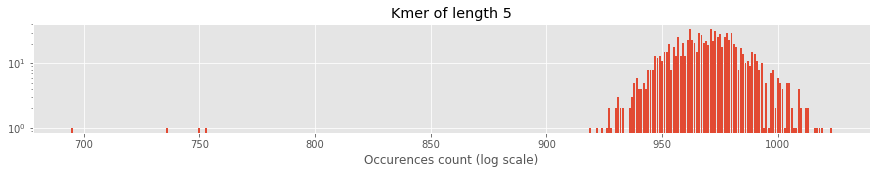

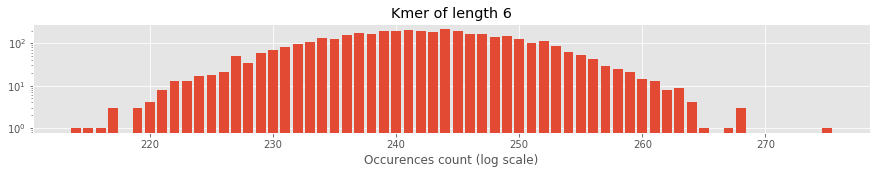

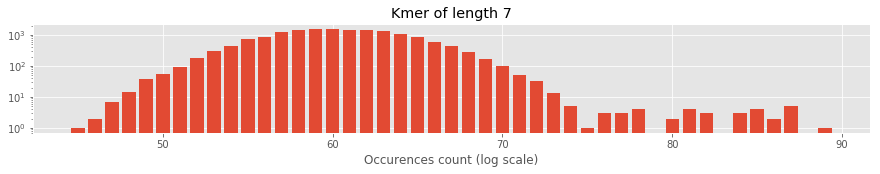

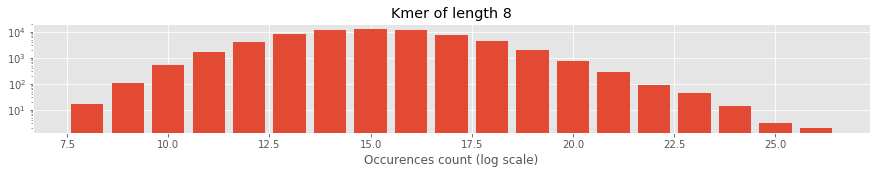

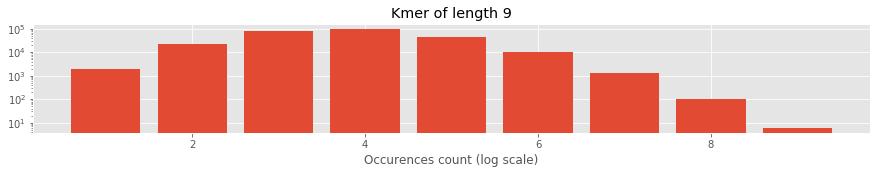

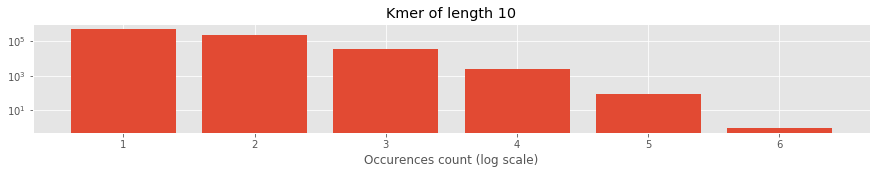

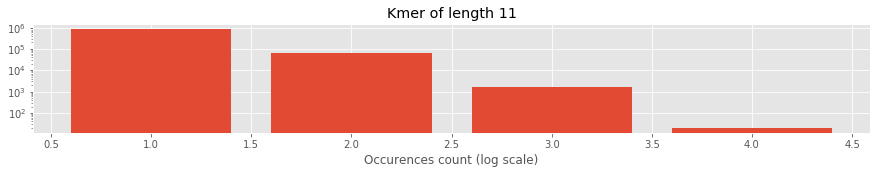

,Median occurrences,Mean occurrences,Min occurrences,Max occurrences,kmers found,kmers expected,Percent kmers found
5-mers,970.0,968.0,695.0,1023.0,1024.0,1024.0,100.00
6-mers,242.0,241.0,214.0,275.0,4092.0,4092.0,100.00
7-mers,60.0,60.0,45.0,89.0,16356.0,16356.0,100.00
8-mers,15.0,15.0,8.0,26.0,65376.0,65376.0,100.00
9-mers,4.0,3.0,0.0,9.0,261268.0,261312.0,99.98
10-mers,1.0,1.0,0.0,6.0,706080.0,1044480.0,67.60
11-mers,1.0,1.0,0.0,4.0,913965.0,4174848.0,21.89


In [69]:
fa = "./data/references/random_guided_weight.fa"
plot_kmer_content (fa, min_kmer=5, max_kmer=11)

## Test if sequence are sufficiently different from each other

Pairwise comparison of all sequences generated using a Banded Striped Smith Waterman alignment

100%|██████████| 2000/2000 [13:59<00:00,  2.41it/s]


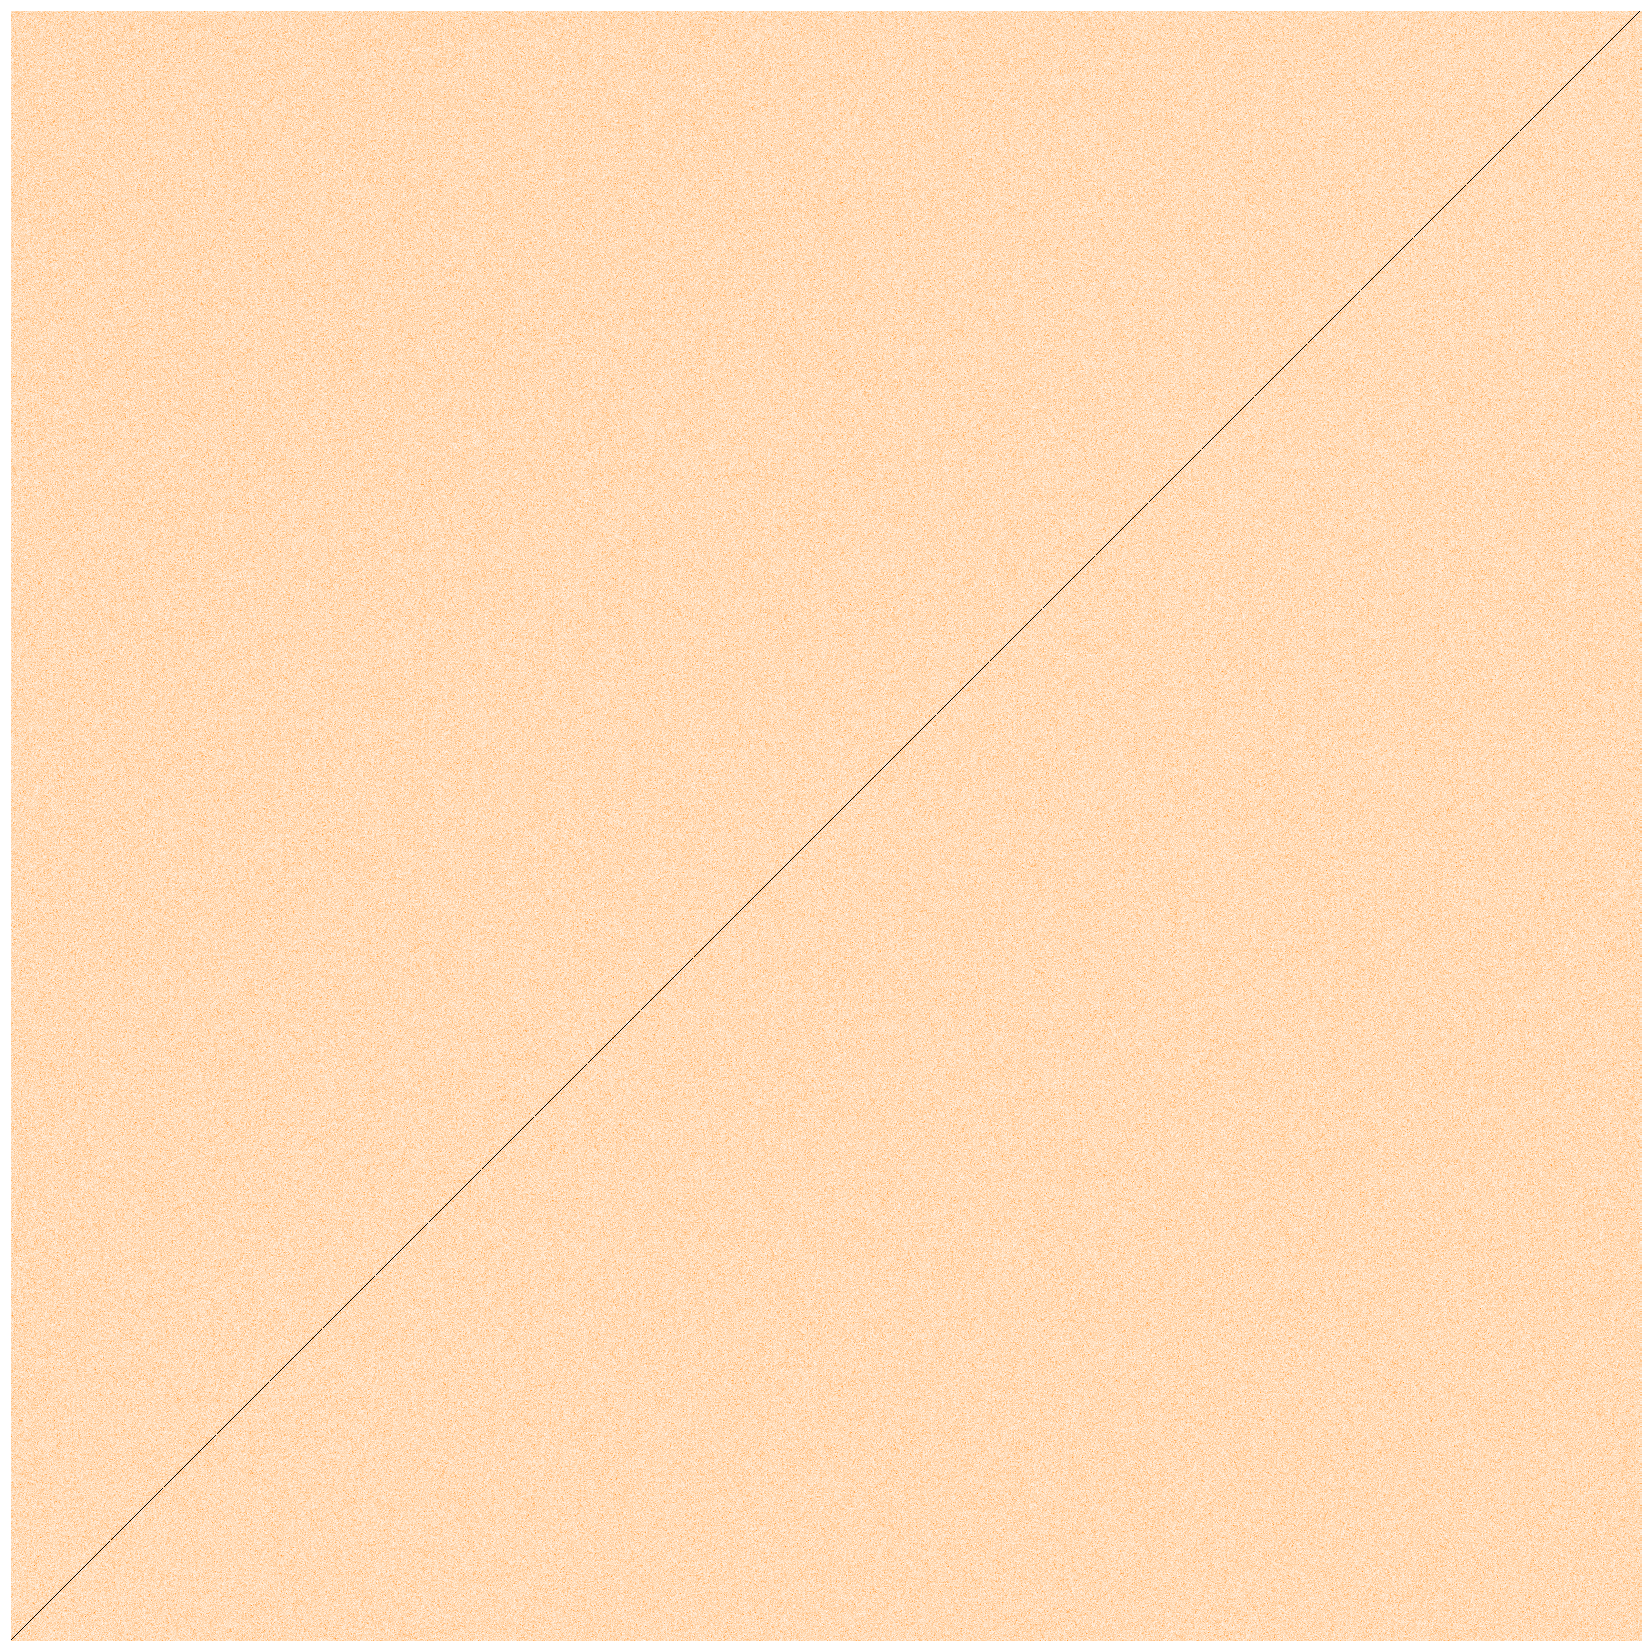

In [10]:
fa = "./data/references/random_guided_weight.fa"

with pyfaidx.Fasta(fasta_fn) as fa:
    n_seq = len(fa.keys())
    a = np.zeros(shape=(n_seq,n_seq), dtype=int)
    for i in trange(n_seq):
        query = StripedSmithWaterman(str(fa[i]))
        for j in range(n_seq):
            align = query(str(fa[j]))
            a[i][n_seq-j-1] = align["optimal_alignment_score"]

with pl.style.context("ggplot"):
    fig, ax = pl.subplots(figsize=(30,30))
    sns.heatmap (data=np.log(a), ax=ax, cmap="gist_heat_r", square=True, cbar=False, xticklabels=False, yticklabels=False)

Great !